In [92]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import numpy as np
import netCDF4 as nc

from scipy.interpolate import interp1d

import sys
sys.path.append('../src/')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from TamocWrapper import run_tamoc_sbm, parse_tamoc_sbm_results, setup_ambient_profile, get_bubble_diameter
from FateModel import run_eulerian, run_one_year, run_ensemble
from PlotterFunctions import plot_massbalance, plot_parameter_scan

In [3]:
def get_kw(U):
    Sc = 677
    a = 6.97e-7
    return a * U**2 * (Sc/660)**(-0.5)

In [5]:
# Get data from GOTM file
#d = nc.Dataset('/home/torn/Projects/GOTM/cases/nns_annual/nns_annual.nc')
d = nc.Dataset('/home/torn/Projects/GOTM/cases-6.0/case1_methane/case1.nc')

for k, v in d.variables.items():
    print(f'{k}, \t {v.long_name}')

time, 	 time
lon, 	 longitude
lat, 	 latitude
temp, 	 potential temperature
salt, 	 salinity
rho, 	 potential density
temp_obs, 	 observed temperature
salt_obs, 	 observed salinity
u, 	 x-velocity
v, 	 y-velocity
xP, 	 extra turbulence production
h, 	 layer thickness
num, 	 turbulent diffusivity of momentum
nuh, 	 turbulent diffusivity of heat
nus, 	 turbulent diffusivity of salt
tke, 	 turbulent kinetic energy
eps, 	 energy dissipation rate
u_obs, 	 observed x-velocity
v_obs, 	 observed y-velocity
fric, 	 extra friction coefficient in water column
drag, 	 drag coefficient in water column
SS, 	 shear frequency squared
P, 	 shear production
uu, 	 variance of u-fluctuations
vv, 	 variance of v-fluctuations
ww, 	 variance of w-fluctuations
NN, 	 buoyancy frequency squared
NNT, 	 contribution of T-gradient to buoyancy frequency squared
NNS, 	 contribution of S-gradient to buoyancy frequency squared
buoy, 	 buoyancy
kb, 	 (half) buoyancy variance
epsb, 	 destruction of buoyancy variance
G, 

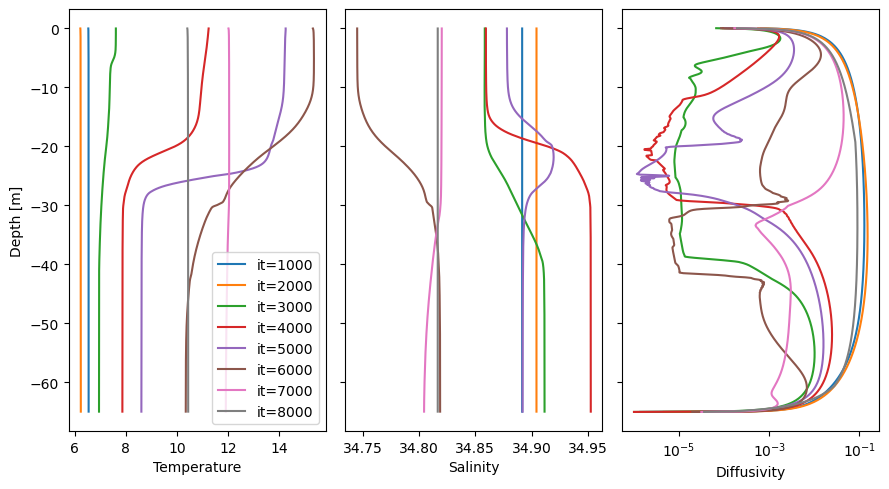

In [77]:
# Get data from GOTM file
d = nc.Dataset('/home/torn/Projects/GOTM/cases-6.0/case1_methane/case1.nc')
K_gotm = d.variables['nus'][:,:,0,0]
z_gotm = d.variables['z' ][0,:,0,0]
zi_gotm = d.variables['zi' ][0,:,0,0]
T_gotm = d.variables['temp'][:,:,0,0]
S_gotm = d.variables['salt'][:,:,0,0]

# Deal with zero at boundaries by linear interpolation
K_gotm[:,0]  = np.maximum(1e-6, K_gotm[:,1] - (K_gotm[:,2]-K_gotm[:,1]))
K_gotm[:,-1] = np.maximum(1e-6, K_gotm[:,-2] - (K_gotm[:,-3]-K_gotm[:,-2]))
assert np.all(K_gotm > 0)


fig, ax = plt.subplots(ncols=3, figsize=(9,5), sharey=True)
for it in range(1000, 8100, 1000):

    ax[0].plot(T_gotm[it,:], z_gotm, label=f'it={it}')
    ax[1].plot(S_gotm[it,:], z_gotm)
    ax[2].plot(K_gotm[it,:], zi_gotm)

ax[2].set_xscale('log')

ax[0].legend()
ax[0].set_ylabel('Depth [m]')
ax[0].set_xlabel('Temperature')
ax[1].set_xlabel('Salinity')
ax[2].set_xlabel('Diffusivity')
plt.tight_layout()

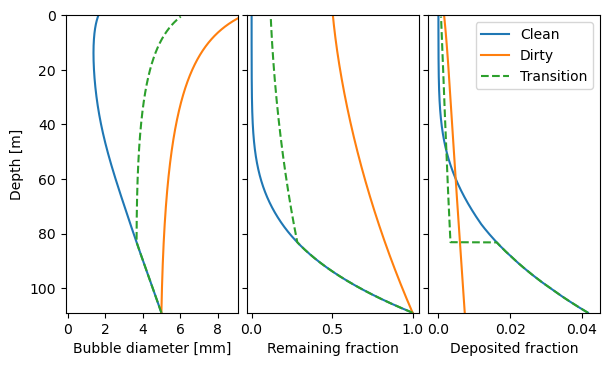

In [71]:
# Get data from GOTM file
ds = nc.Dataset('/home/torn/Projects/GOTM/cases/nns_annual/nns_annual.nc')

it = 1500

z_gotm = np.abs(ds.variables['z' ][0,:,0,0])
T_gotm = ds.variables['temp_i'][it,:,0,0]
S_gotm = ds.variables['salt_p'][it,:,0,0]

profile = setup_ambient_profile(z_gotm, T_gotm, S_gotm)


# Release depth, in meters
z0 = 109
# Initial diameter, in meters
d0 = 5e-3


fig, ax = plt.subplots(ncols=3, figsize=(6, 3.5), sharey=True)

for t_hyd, label, lt in zip([np.inf, 0, 100], ['Clean', 'Dirty', 'Transition'], ['-', '-', '--']):
    bub, sbm = run_tamoc_sbm(z0, d0, profile, t_hyd=t_hyd)
    depth, remaining, deposited, direct = parse_tamoc_sbm_results(sbm, z0)

    z, d = get_bubble_diameter(bub, sbm, profile)

    ax[0].plot(1000*d, z, lt)
    ax[1].plot(remaining[:-1], depth, lt)
    ax[2].plot(deposited, depth, lt, label=label)

ax[0].set_ylim(z0, 0)
ax[0].set_xlim(-0.1, 9.1)
ax[1].set_xlim(-0.03, 1.04)
ax[2].set_xlim(-0.003, 0.045)

ax[0].set_xticks([0, 2, 4, 6, 8])
ax[2].set_xticks([0, 0.02, 0.04])
ax[2].set_xticklabels(['0.0', 0.02, 0.04])

ax[2].legend()
ax[0].set_ylabel('Depth [m]')
ax[0].set_xlabel('Bubble diameter [mm]')
ax[1].set_xlabel('Remaining fraction')
ax[2].set_xlabel('Deposited fraction')
plt.subplots_adjust(left=0.1, bottom=0.13, right=0.99, top=0.98, wspace=0.05)

plt.savefig('bubble_example.png', dpi=240)
plt.savefig('bubble_example.pdf')

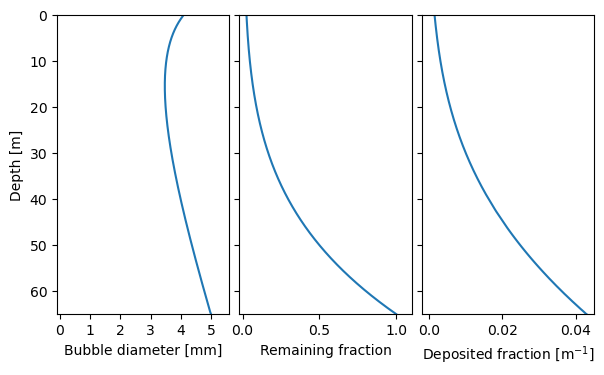

In [18]:
# Get data from GOTM file
#ds = nc.Dataset('/home/torn/Projects/GOTM/cases/nns_annual/nns_annual.nc')
ds = nc.Dataset('/home/torn/Projects/GOTM/cases-6.0/case1_methane/case1.nc')


it = 1500

z_gotm = np.abs(ds.variables['z' ][0,:,0,0])
T_gotm = ds.variables['temp'][it,:,0,0]
S_gotm = ds.variables['salt'][it,:,0,0]

profile = setup_ambient_profile(z_gotm, T_gotm, S_gotm)


# Release depth, in meters
z0 = 65
# Initial diameter, in meters
d0 = 5e-3


fig, ax = plt.subplots(ncols=3, figsize=(6, 3.5), sharey=True)

t_hyd = np.inf
lt = '-'

bub, sbm = run_tamoc_sbm(z0, d0, profile, t_hyd=t_hyd)
depth, remaining, deposited, direct = parse_tamoc_sbm_results(sbm, z0)

z, d = get_bubble_diameter(bub, sbm, profile)

ax[0].plot(1000*d, z, lt)
ax[1].plot(remaining[:-1], depth, lt)
ax[2].plot(deposited, depth, lt)

ax[0].set_ylim(z0, 0)
ax[0].set_xlim(-0.1, 5.6)
ax[1].set_xlim(-0.02, 1.1)
ax[2].set_xlim(-0.002, 0.045)

ax[0].set_xticks([0, 1, 2, 3, 4, 5])
ax[2].set_xticks([0, 0.02, 0.04])
ax[2].set_xticklabels(['0.0', 0.02, 0.04])

#ax[2].legend()
ax[0].set_ylabel('Depth [m]')
ax[0].set_xlabel('Bubble diameter [mm]')
ax[1].set_xlabel('Remaining fraction')
ax[2].set_xlabel('Deposited fraction [m$^{-1}$]')
plt.subplots_adjust(left=0.095, bottom=0.125, right=0.99, top=0.98, wspace=0.06)

plt.savefig('bubble_example_clean.png', dpi=240)
plt.savefig('bubble_example_clean.pdf')

0.003 0.0
0.005 2.319254611959122e-05
0.008 0.02132367609903132


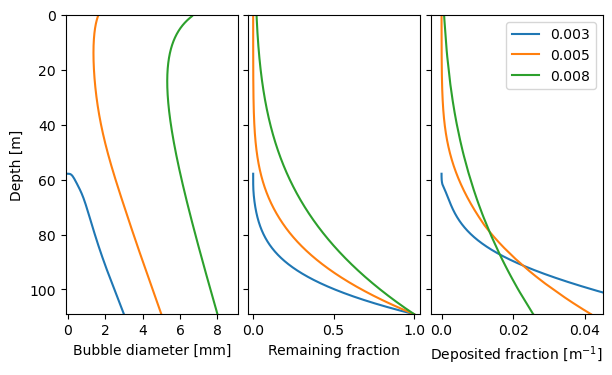

In [84]:
# Get data from GOTM file
ds = nc.Dataset('/home/torn/Projects/GOTM/cases/nns_annual/nns_annual.nc')

it = 1500

z_gotm = np.abs(ds.variables['z' ][0,:,0,0])
T_gotm = ds.variables['temp_i'][it,:,0,0]
S_gotm = ds.variables['salt_p'][it,:,0,0]

profile = setup_ambient_profile(z_gotm, T_gotm, S_gotm)


# Release depth, in meters
z0 = 109



fig, ax = plt.subplots(ncols=3, figsize=(6, 3.5), sharey=True)

t_hyd = np.inf
lt = '-'


# Initial diameter, in meters
for d0 in [3e-3, 5e-3, 8e-3]:

    bub, sbm = run_tamoc_sbm(z0, d0, profile, t_hyd=t_hyd)
    depth, remaining, deposited, direct = parse_tamoc_sbm_results(sbm, z0)
    print(d0, direct)
    
    z, d = get_bubble_diameter(bub, sbm, profile)
    
    ax[0].plot(1000*d, z, lt)
    ax[1].plot(remaining[:-1], depth, lt)
    ax[2].plot(deposited, depth, lt, label=d0)
    
ax[0].set_ylim(z0, 0)
ax[0].set_xlim(-0.1, 9.1)
ax[1].set_xlim(-0.03, 1.04)
ax[2].set_xlim(-0.003, 0.045)

ax[0].set_xticks([0, 2, 4, 6, 8])
ax[2].set_xticks([0, 0.02, 0.04])
ax[2].set_xticklabels(['0.0', 0.02, 0.04])

ax[2].legend()
ax[0].set_ylabel('Depth [m]')
ax[0].set_xlabel('Bubble diameter [mm]')
ax[1].set_xlabel('Remaining fraction')
ax[2].set_xlabel('Deposited fraction [m$^{-1}$]')
plt.subplots_adjust(left=0.095, bottom=0.125, right=0.99, top=0.98, wspace=0.06)

plt.savefig('bubble_example_clean_multisize.png', dpi=240)
plt.savefig('bubble_example_clean_multisize.pdf')

Mass balance at end of simulation:
Direct      =  0.025333903289082006
Evaporated  =  0.8004919437526178
Dissolved   =  0.014979052809231518
Biodegraded =  0.15919509997991815
Total       =  0.9999999998308495


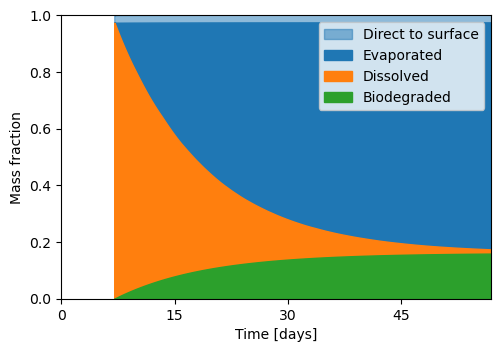

In [4]:
# Get data from GOTM file
#ds = nc.Dataset('/home/torn/Projects/GOTM/cases/nns_annual/nns_annual.nc')
ds = nc.Dataset('/home/torn/Projects/GOTM/cases-6.0/case1_methane/case1.nc')


# Release depth, in meters
z0 = 65
# Initial diameter, in meters
d0 = 5e-3
# Simulationtime
t0 = 7*24*3600
#t0 = 180 * 24*3600
Tmax = t0 + 50*24*3600
dt = 600

z_gotm = np.abs(ds.variables['z' ][0,:,0,0])
zi_gotm = np.abs(ds.variables['zi'][0,:,0,0])
K_gotm = ds.variables['nus'][:,:,0,0]
# Deal with zero at boundaries by linear interpolation
#K_gotm[:,0]  = np.maximum(1e-5, K_gotm[:,1] - (K_gotm[:,2]-K_gotm[:,1]))
#K_gotm[:,-1] = np.maximum(1e-5, K_gotm[:,-2] - (K_gotm[:,-3]-K_gotm[:,-2]))
assert np.all(K_gotm >= 0)

# Creat grid for Eulerian diffusion-reaction solver
zf, dz = np.linspace(0, z0, 651, retstep=True)
zc = zf[:-1] + dz/2

# Interpolate diffusivity to grid
K = np.zeros((len(zf), K_gotm.shape[0]))
K_times = ds.variables['time'][:]
for it in range(K.shape[1]):
    K[:,it] = np.interp(zf, zi_gotm[::-1], K_gotm[it,::-1])


# Create profile for TAMOC simulation
it = np.searchsorted(K_times, t0)
T_gotm = ds.variables['temp'][it,:,0,0]
S_gotm = ds.variables['salt'][it,:,0,0]

profile = setup_ambient_profile(z_gotm, T_gotm, S_gotm)
# Hydrate formation time. inf => clean bubble
t_hyd = np.inf

bub, sbm = run_tamoc_sbm(z0, d0, profile, t_hyd=t_hyd)
depth, remaining, deposited, direct = parse_tamoc_sbm_results(sbm, z0)

# Mass transfer coefficient
kw = get_kw(9)
# Biodegradation half-life
halflife = 50 * 24*3600

C, evap, biod, tc = run_eulerian(depth, deposited, direct, zc, K, halflife, kw, Tmax, dt=dt, t0=t0, K_times=K_times)

plot_massbalance(C, evap, biod, zc, tc)

print('Mass balance at end of simulation:')
print('Direct      = ', direct)
print('Evaporated  = ', evap[-1])
print('Dissolved   = ', np.sum(C[-1,:]*dz))
print('Biodegraded = ', biod[-1])
print('Total       = ', np.sum(C[-1,:]*dz) + biod[-1] + evap[-1] + direct)

Mass balance at end of simulation:
Direct      =  0.025331116422725588
Evaporated  =  0.7997307730285809
Dissolved   =  0.015041618966287883
Biodegraded =  0.15989649146275942
Total       =  0.9999999998803537
Mass balance at end of simulation:
Direct      =  0.024995572058800535
Evaporated  =  0.09448770815444081
Dissolved   =  0.4329144790440819
Biodegraded =  0.4476022409289582
Total       =  1.0000000001862814


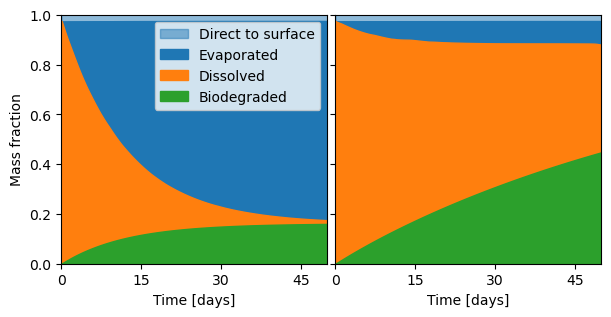

In [104]:
# Get data from GOTM file
#ds = nc.Dataset('/home/torn/Projects/GOTM/cases/nns_annual/nns_annual.nc')
ds = nc.Dataset('/home/torn/Projects/GOTM/cases-6.0/case1_methane/case1.nc')

# Release depth, in meters
z0 = 65
# Initial diameter, in meters
d0 = 5e-3

fig, ax = plt.subplots(ncols=2, sharey=True, sharex=True, figsize=(6, 3))

for i, t0 in enumerate([6*24*2600, 186*24*3600]):
    Tmax = t0 + 50*24*3600
    dt = 600
    
    z_gotm = np.abs(ds.variables['z' ][0,:,0,0])
    zi_gotm = np.abs(ds.variables['zi'][0,:,0,0])
    K_gotm = ds.variables['nus'][:,:,0,0]
    # Deal with zero at boundaries by linear interpolation
    #K_gotm[:,0]  = np.maximum(1e-5, K_gotm[:,1] - (K_gotm[:,2]-K_gotm[:,1]))
    #K_gotm[:,-1] = np.maximum(1e-5, K_gotm[:,-2] - (K_gotm[:,-3]-K_gotm[:,-2]))
    assert np.all(K_gotm >= 0)
    
    # Creat grid for Eulerian diffusion-reaction solver
    zf, dz = np.linspace(0, z0, 651, retstep=True)
    zc = zf[:-1] + dz/2
    
    # Interpolate diffusivity to grid
    K = np.zeros((len(zf), K_gotm.shape[0]))
    K_times = ds.variables['time'][:]
    for it in range(K.shape[1]):
        K[:,it] = np.interp(zf, zi_gotm[::-1], K_gotm[it,::-1])
    
    
    # Create profile for TAMOC simulation
    it = np.searchsorted(K_times, t0)
    T_gotm = ds.variables['temp'][it,:,0,0]
    S_gotm = ds.variables['salt'][it,:,0,0]
    
    
    bub, sbm = run_tamoc_sbm(z0, d0, profile, t_hyd=t_hyd)
    depth, remaining, deposited, direct = parse_tamoc_sbm_results(sbm, z0)
    
    # Mass transfer coefficient
    kw = get_kw(9)
    # Biodegradation half-life
    halflife = 50 * 24*3600

    
    C, evap, biod, tc = run_eulerian(depth, deposited, direct, zc, K, halflife, kw, Tmax, dt=dt, t0=t0, K_times=K_times)
    
    plot_massbalance(C, evap, biod, zc, tc-tc[0], ax=ax[i], ylabel=['Mass fraction', ''][i], legend = [1, 0][i], savefig=False)
    
    print('Mass balance at end of simulation:')
    print('Direct      = ', direct)
    print('Evaporated  = ', evap[-1])
    print('Dissolved   = ', np.sum(C[-1,:]*dz))
    print('Biodegraded = ', biod[-1])
    print('Total       = ', np.sum(C[-1,:]*dz) + biod[-1] + evap[-1] + direct)

plt.subplots_adjust(left=0.09, bottom=0.15, right=0.99, top=0.98, wspace=0.03)
plt.savefig('massbalance_two_examples.png', dpi=240)
plt.savefig('massbalance_two_examples.pdf')

In [5]:
print(zi_gotm.shape)
print(z_gotm.shape)

(651,)
(650,)


In [4]:
ds = nc.Dataset('/home/torn/Projects/GOTM/cases-6.0/case1_methane/case1.nc')

# Release depth, in meters
z0 = 65
# Initial diameter, in meters
d0 = 5e-3
# Biodegradation half-life, in seconds
halflife = 10*24*3600
# Mass-transfer coefficient
kw = get_kw(9)
# Number of runs in ensemble
Nruns = 12

z_gotm  = np.array(np.abs(ds.variables['z' ][0,::-1,0,0]))
zi_gotm = np.array(np.abs(ds.variables['zi'][0,::-1,0,0]))
t_gotm  = np.array(ds.variables['time'][:])
T_gotm  = np.array(ds.variables['temp'][:,::-1,0,0])
S_gotm  = np.array(ds.variables['salt'][:,::-1,0,0])
K_gotm  = np.array(ds.variables['nus'][:,::-1,0,0])
assert np.all(K_gotm >= 0)

direct, dissolved, biodegraded, evaporated, tc = run_ensemble(z0, d0, halflife, kw, Nruns, z_gotm, T_gotm, S_gotm, zi_gotm, K_gotm, t_gotm)




  8%|███████████████████████████▎                                                                                                                                                                                                                                                                                                            | 1/12 [00:02<00:25,  2.28s/it]capi_return is NULL
Call-back cb_f_in_dvode__user__routines failed.
  8%|███████████████████████████▎                                                                                                                                                                                                                                                                                                            | 1/12 [00:03<00:34,  3.15s/it]


KeyboardInterrupt: 

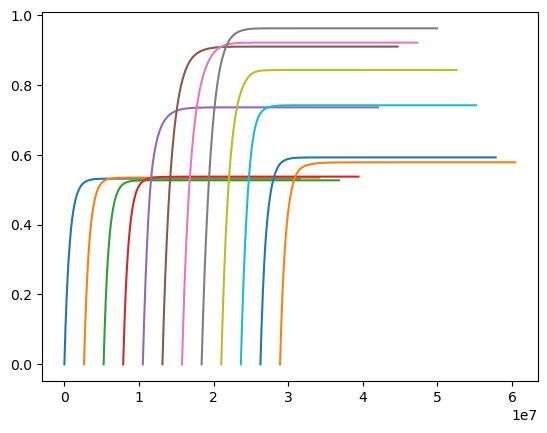

In [59]:
for it in range(12):
    plt.plot(tc[it,:], biodegraded[it,:])


In [101]:
ds = nc.Dataset('/home/torn/Projects/GOTM/cases-6.0/case1_methane/case1.nc')

# Release depth, in meters
z0 = 65
# Initial diameter, in meters
d0 = 5e-3

z_gotm  = np.array(np.abs(ds.variables['z' ][0,::-1,0,0]))
zi_gotm = np.array(np.abs(ds.variables['zi'][0,::-1,0,0]))
t_gotm  = np.array(ds.variables['time'][:])
T_gotm  = np.array(ds.variables['temp'][:,::-1,0,0])
S_gotm  = np.array(ds.variables['salt'][:,::-1,0,0])
K_gotm  = np.array(ds.variables['nus'][:,::-1,0,0])
assert np.all(K_gotm >= 0)

halflife_days_list = np.logspace(0, np.log10(500), 12)

direct_list1 = np.zeros_like(halflife_days_list)
dissolved_list1 = np.zeros_like(halflife_days_list)
biodegraded_list1 = np.zeros_like(halflife_days_list)
evaporated_list1 = np.zeros_like(halflife_days_list)

for i, halflife_days in enumerate(halflife_days_list):
    # Biodegradation half-life, in seconds
    halflife = halflife_days * 24*3600
    # Mass-transfer coefficient
    kw = get_kw(9)
    # Number of runs in ensemble
    Nruns = 12
    
    direct, dissolved, biodegraded, evaporated, tc = run_ensemble(z0, d0, halflife, kw, Nruns, z_gotm, T_gotm, S_gotm, zi_gotm, K_gotm, t_gotm, dt=600)

    direct_list1[i] = np.mean(direct[:,-1])
    dissolved_list1[i] = np.mean(dissolved[:,-1])
    biodegraded_list1[i] = np.mean(biodegraded[:,-1])
    evaporated_list1[i] = np.mean(evaporated[:,-1])

    print(direct[:, 0] + dissolved[:, 0] + biodegraded[:, 0] + evaporated[:, 0])
    print(direct[:,-1] + dissolved[:,-1] + biodegraded[:,-1] + evaporated[:,-1])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:27<00:00,  2.33s/it]


[0.99999985 0.99999985 0.99999985 0.99999985 0.99999985 0.99999985
 0.99999985 0.99999985 0.99999985 0.99999985 0.99999985 0.99999985]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:34<00:00,  2.87s/it]


[0.99999985 0.99999985 0.99999985 0.99999985 0.99999985 0.99999985
 0.99999985 0.99999985 0.99999985 0.99999985 0.99999985 0.99999985]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:44<00:00,  3.73s/it]


[0.99999985 0.99999985 0.99999985 0.99999985 0.99999985 0.99999985
 0.99999985 0.99999985 0.99999985 0.99999985 0.99999985 0.99999985]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [01:00<00:00,  5.07s/it]


[0.99999985 0.99999985 0.99999985 0.99999985 0.99999985 0.99999985
 0.99999985 0.99999985 0.99999985 0.99999985 0.99999985 0.99999985]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [01:25<00:00,  7.16s/it]


[0.99999985 0.99999985 0.99999985 0.99999985 0.99999985 0.99999985
 0.99999985 0.99999985 0.99999985 0.99999985 0.99999985 0.99999985]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [02:07<00:00, 10.62s/it]


[0.99999985 0.99999985 0.99999985 0.99999985 0.99999985 0.99999985
 0.99999985 0.99999985 0.99999985 0.99999985 0.99999985 0.99999985]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [03:18<00:00, 16.55s/it]


[0.99999985 0.99999985 0.99999985 0.99999985 0.99999985 0.99999985
 0.99999985 0.99999985 0.99999985 0.99999985 0.99999985 0.99999985]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [04:02<00:00, 20.23s/it]


[0.99999985 0.99999985 0.99999985 0.99999985 0.99999985 0.99999985
 0.99999985 0.99999985 0.99999985 0.99999985 0.99999985 0.99999985]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [04:17<00:00, 21.47s/it]


[0.99999985 0.99999985 0.99999985 0.99999985 0.99999985 0.99999985
 0.99999985 0.99999985 0.99999985 0.99999985 0.99999985 0.99999985]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [04:19<00:00, 21.63s/it]


[0.99999985 0.99999985 0.99999985 0.99999985 0.99999985 0.99999985
 0.99999985 0.99999985 0.99999985 0.99999985 0.99999985 0.99999985]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [04:19<00:00, 21.65s/it]


[0.99999985 0.99999985 0.99999985 0.99999985 0.99999985 0.99999985
 0.99999985 0.99999985 0.99999985 0.99999985 0.99999985 0.99999985]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [04:19<00:00, 21.66s/it]

[0.99999985 0.99999985 0.99999985 0.99999985 0.99999985 0.99999985
 0.99999985 0.99999985 0.99999985 0.99999985 0.99999985 0.99999985]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


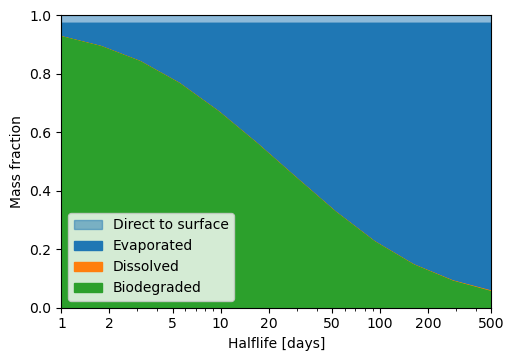

In [102]:
ticks = [1, 2, 5, 10, 20, 50, 100, 200, 500]
plot_parameter_scan(direct_list1, dissolved_list1, evaporated_list1, biodegraded_list1, halflife_days_list, 'Halflife [days]', ticks, filename='massbalance_case1.pdf', loc='lower left')



In [107]:
ds = nc.Dataset('/home/torn/Projects/GOTM/cases-6.0/case2_methane/case2.nc')

# Release depth, in meters
z0 = 109
# Initial diameter, in meters
d0 = 5e-3

z_gotm  = np.array(np.abs(ds.variables['z' ][0,::-1,0,0]))
zi_gotm = np.array(np.abs(ds.variables['zi'][0,::-1,0,0]))
t_gotm  = np.array(ds.variables['time'][:])
T_gotm  = np.array(ds.variables['temp'][:,::-1,0,0])
S_gotm  = np.array(ds.variables['salt'][:,::-1,0,0])
K_gotm  = np.array(ds.variables['nus'][:,::-1,0,0])
assert np.all(K_gotm >= 0)

halflife_days_list = np.logspace(0, np.log10(500), 12)

direct_list2 = np.zeros_like(halflife_days_list)
dissolved_list2 = np.zeros_like(halflife_days_list)
biodegraded_list2 = np.zeros_like(halflife_days_list)
evaporated_list2 = np.zeros_like(halflife_days_list)

for i, halflife_days in enumerate(halflife_days_list):
    # Biodegradation half-life, in seconds
    halflife = halflife_days * 24*3600
    # Mass-transfer coefficient
    kw = get_kw(9)
    # Number of runs in ensemble
    Nruns = 12
    
    direct, dissolved, biodegraded, evaporated, tc = run_ensemble(z0, d0, halflife, kw, Nruns, z_gotm, T_gotm, S_gotm, zi_gotm, K_gotm, t_gotm, dt=600)

    direct_list2[i] = np.mean(direct[:,-1])
    dissolved_list2[i] = np.mean(dissolved[:,-1])
    biodegraded_list2[i] = np.mean(biodegraded[:,-1])
    evaporated_list2[i] = np.mean(evaporated[:,-1])

#    print(direct[:, 0] + dissolved[:, 0] + biodegraded[:, 0] + evaporated[:, 0])
#    print(direct[:,-1] + dissolved[:,-1] + biodegraded[:,-1] + evaporated[:,-1])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [09:53<00:00, 49.48s/it]


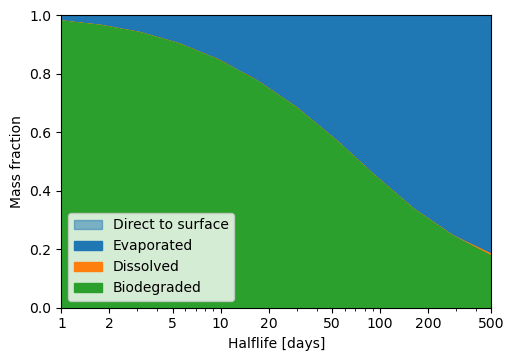

In [108]:
ticks = [1, 2, 5, 10, 20, 50, 100, 200, 500]
plot_parameter_scan(direct_list2, dissolved_list2, evaporated_list2, biodegraded_list2, halflife_days_list, 'Halflife [days]', ticks, filename='massbalance_case2.pdf', loc='lower left')



In [ ]:
ds = nc.Dataset('/home/torn/Projects/GOTM/cases-6.0/case3_methane/case3.nc')

# Release depth, in meters
z0 = 302
# Initial diameter, in meters
d0 = 5e-3

z_gotm  = np.array(np.abs(ds.variables['z' ][0,::-1,0,0]))
zi_gotm = np.array(np.abs(ds.variables['zi'][0,::-1,0,0]))
t_gotm  = np.array(ds.variables['time'][:])
T_gotm  = np.array(ds.variables['temp'][:,::-1,0,0])
S_gotm  = np.array(ds.variables['salt'][:,::-1,0,0])
K_gotm  = np.array(ds.variables['nus'][:,::-1,0,0])
assert np.all(K_gotm >= 0)

halflife_days_list = np.logspace(0, np.log10(500), 12)

direct_list3 = np.zeros_like(halflife_days_list)
dissolved_list3 = np.zeros_like(halflife_days_list)
biodegraded_list3 = np.zeros_like(halflife_days_list)
evaporated_list3 = np.zeros_like(halflife_days_list)

for i, halflife_days in enumerate(halflife_days_list):
    # Biodegradation half-life, in seconds
    halflife = halflife_days * 24*3600
    # Mass-transfer coefficient
    kw = get_kw(9)
    # Number of runs in ensemble
    Nruns = 12
    
    direct, dissolved, biodegraded, evaporated, tc = run_ensemble(z0, d0, halflife, kw, Nruns, z_gotm, T_gotm, S_gotm, zi_gotm, K_gotm, t_gotm, dt=600)

    direct_list3[i] = np.mean(direct[:,-1])
    dissolved_list3[i] = np.mean(dissolved[:,-1])
    biodegraded_list3[i] = np.mean(biodegraded[:,-1])
    evaporated_list3[i] = np.mean(evaporated[:,-1])

#    print(direct[:, 0] + dissolved[:, 0] + biodegraded[:, 0] + evaporated[:, 0])
#    print(direct[:,-1] + dissolved[:,-1] + biodegraded[:,-1] + evaporated[:,-1])


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 7/12 [24:13<17:18, 207.70s/it]

In [ ]:
ticks = [1, 2, 5, 10, 20, 50, 100, 200, 500]
plot_parameter_scan(direct_list3, dissolved_list3, evaporated_list3, biodegraded_list3, halflife_days_list, 'Halflife [days]', ticks, filename='massbalance_case3.pdf', loc='lower left')



In [48]:
deposited[-1], depth[-1], z_gotm[-1]

(0.0014456645686824088, 0.0736569997093339, 64.95)

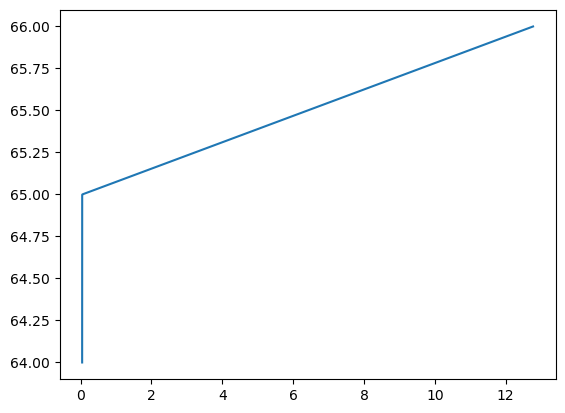

In [49]:
z = np.linspace(64, 66, 1000)
plt.plot(interp1d(depth[:], deposited[:], fill_value='extrapolate', bounds_error=False, kind='linear')(z), z)

In [56]:
np.amax(K_gotm)

0.23561102

In [94]:
kw = get_kw(9)

Bi = kw * 65 / 1e-2

print(Bi)

0.36233374855069206
